<p style="font-size:30px"><b> IMDB Review Sentiment Classification </b></p>
<p style="font-size:20px"> by Aditya Tyagi </p>


**Problem Statement**: 

Perform Sentiment analysis on IMDB Dataset of 50K Movie Reviews. Do a thorough Exploratory Data Analysis of the dataset and report the final performance metrics for your approach. Suggest ways in which you can improve the model.


**Tips**
- Ask yourself why would they have selected this problem for the challenge? What are some gotchas in this domain I should know about?
- What is the highest level of accuracy that others have achieved with this dataset or similar problems / datasets ?
- What types of visualizations will help me grasp the nature of the problem / data?
- What feature engineering might help improve the signal?
- Which modeling techniques are good at capturing the types of relationships I see in this data?
- Now that I have a model, how can I be sure that I didn't introduce a bug in the code? If results are too good to be true, they probably are!
- What are some of the weaknesses of the model and and how can the model be improved with additional work

**Key Takeaway**

- A logistic regression model with the below parameters and a tfidf unigram feature set performs best. It has a accuracy of 0.875 (train=0.896), and an F1 score of 0.876 (train=0.898). 
    * C=1, penalty='l1' || tfidf_1
- A supplementary LDA model then identifies the key topics driving each sentiment prediction. One appropriate number of topics to look for is 3. 


**Approach**

My general approach is to take construct three sets of features (tfidf, doc2vec, glove), and then try out each of them with an ML model to see which combination performs best. Finally, I determine a business use case for my project, by implementing an LDA approach for predictions generated by the sentiment classification model. 

1. Parse data
2. Exploratory Data Analysis
3. Feature Engineering
    * tfidf representation
    * doc2vec embedding
    * glove embedding
4. Model Development
    * Logistic Regression 
    * Support Vector Machine
    * k-Nearest Neighbor Classifier
    * Random Forest
    * Gradient Boosting classifier
5. Model Interpretation
    * Plotting ROC curve and optimal decision threshold identification
    * Identification of coefficients
6. Business Context
    * Segment predictiions by sentiment
    * LDA Topic Model
7. Next Steps


**Background & Benchmarking**

In the paper accompanying the dataset, Pang et al obtain an accuracy of ~87% on this dataset, using a BoW approach and optimizations introduced in their paper. 

# Parse Data

We begin by parsing the data into a Pandas dataframe, and persisting a a .csv.

In [14]:
import pandas as pd
import seaborn as sns
import numpy as np

In [40]:

BASE_PATH = "aclImdb_v1.tar/aclImdb/train/pos"
file_names = os.listdir("aclImdb_v1.tar/aclImdb/train/pos")


def read_data(base_path, file_names, label):
    data = []
    for file_name in file_names:
        full_path = os.path.join(base_path, file_name) 
        with open(full_path, 'r', encoding='utf8') as f:
            review_id = file_name.split(".")[0].split("_")[0]
            review_rating = file_name.split(".")[0].split("_")[1]
            review_txt = f.read()
            review = {
                'id': review_id,
                'rating': review_rating,
                'text': review_txt,
                'label': label
            }
        data.append(review)
    return data

    
 

In [41]:
train_pos = read_data(base_path="aclImdb_v1.tar/aclImdb/train/pos", 
                      file_names=os.listdir("aclImdb_v1.tar/aclImdb/train/pos"),
                      label='pos')
train_neg = read_data(base_path="aclImdb_v1.tar/aclImdb/train/neg", 
                      file_names= os.listdir("aclImdb_v1.tar/aclImdb/train/neg"),
                      label='neg')
train = train_pos + train_neg

In [49]:
test_pos = read_data(base_path="aclImdb_v1.tar/aclImdb/test/pos", 
                    file_names=os.listdir("aclImdb_v1.tar/aclImdb/test/pos"),
                    label='pos')
test_neg = read_data(base_path="aclImdb_v1.tar/aclImdb/test/neg", 
                    file_names=os.listdir("aclImdb_v1.tar/aclImdb/test/neg"),
                    label='neg')
test = test_pos + test_neg

In [53]:
print(f"No. of training positive examples: {len(train_pos)}")
print(f"No. of training negative examples: {len(train_neg)}")
print(f"Total training examples: {len(train)}")
print("-------------")
print(f"No. of test positive examples: {len(test_pos)}")
print(f"No. of test negative examples: {len(test_neg)}")
print(f"Total test examples: {len(test)}")

No. of training positive examples: 12500
No. of training negative examples: 12500
Total training examples: 25000
-------------
No. of test positive examples: 12500
No. of test negative examples: 12500
Total test examples: 25000


In [ ]:
#store as a pandas df
train = pd.DataFrame({'id': [review['id'] for review in train], 
         'text': [review['text'] for review in train],
         'rating': [review['rating'] for review in train],
         'label': [review['label'] for review in train]
        })

test = pd.DataFrame({'id': [review['id'] for review in test], 
         'text': [review['text'] for review in test],
         'rating': [review['rating'] for review in test],
         'label': [review['label'] for review in test]
        })

In [63]:
train.head()

,id,text,rating,label
0,0,Bromwell High is a cartoon comedy. It ran at t...,9,pos
1,10000,Homelessness (or Houselessness as George Carli...,8,pos
2,10001,Brilliant over-acting by Lesley Ann Warren. Be...,10,pos
3,10002,This is easily the most underrated film inn th...,7,pos
4,10003,This is not the typical Mel Brooks film. It wa...,8,pos


In [62]:
#persist as .csv
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

In [15]:
#read csv's back into pandas dataframes
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

#  Exploratory Data Analysis

## Visualizations
During the EDA phase, we construct various plots and visualizations to aid our analysis of the data. 

C:\Anaconda3\envs\nlp_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

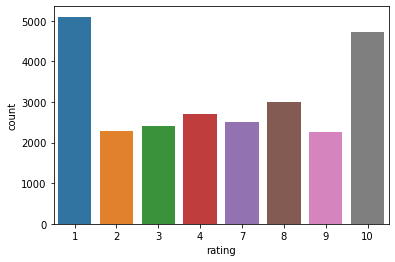

In [4]:
#distribution of ratings - extreme ratings are most common (this is good)
sns.countplot(train['rating'])

C:\Anaconda3\envs\nlp_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

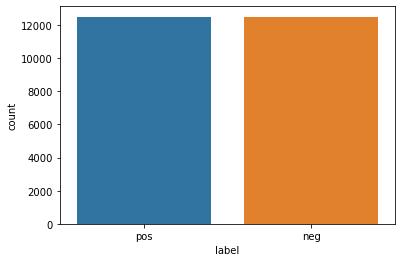

In [65]:
#labels are exactly balanced; this is fantastic!
sns.countplot(train['label'])

In [6]:
#obtain length of review
train['length'] = train['text'].apply(lambda review_text: len(review_text.split(" ")))
train.head()

,id,text,rating,label,length
0,0,Bromwell High is a cartoon comedy. It ran at t...,9,pos,140
1,10000,Homelessness (or Houselessness as George Carli...,8,pos,428
2,10001,Brilliant over-acting by Lesley Ann Warren. Be...,10,pos,147
3,10002,This is easily the most underrated film inn th...,7,pos,124
4,10003,This is not the typical Mel Brooks film. It wa...,8,pos,120


C:\Anaconda3\envs\nlp_env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='length', ylabel='Density'>

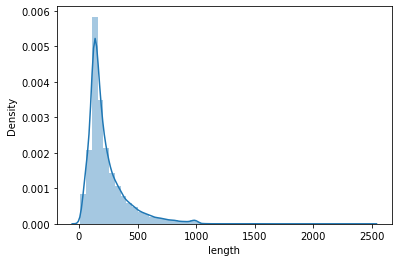

In [71]:
#plot review length
sns.distplot(train['length'])

In [72]:
train['length'].describe()

count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: length, dtype: float64

In [8]:
#positive reviews are slightly longer than negative reviews; 
#positive reviews also have greater variation in their length
train[['label','length', ]].groupby('label').describe()

length                                                          
         count       mean         std   min    25%    50%    75%     max
label                                                                   
neg    12500.0  230.85776  166.647979  10.0  128.0  174.0  278.0  1522.0
pos    12500.0  236.69568  180.465831  12.0  125.0  174.0  291.0  2470.0

## Text Normalization and Sampling

In this step, we normalize the text by carrying out standard preprocessing (lemmatization, stop word removal, punctuation removal, lower-casing, etc.). 

In [4]:
#find most common words in each of positive and negative classes, after preprocessing

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from joblib import delayed, Parallel
import multiprocessing


def preproc(txt):
    stopword_list = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    #lower case
    txt = txt.lower()
    #tokenize
    word_list = word_tokenize(txt)
    #remove punctuation
    word_list = [word for word in word_list if word.isalnum()]
    #remove numbers
    word_list = [word for word in word_list if not word.isnumeric()]
    #remove stopwords
    word_list = [word for word in word_list if word not in stopword_list]
    #stem the words
    word_list = [lemmatizer.lemmatize(word) for word in word_list]
    return " ".join(word_list)

train['preproc_text'] = train['text'].apply(preproc)
test['preproc_text'] = test['text'].apply(preproc)

In [6]:
#persist
train.to_csv("train_proc.csv", index=False)
test.to_csv("test_proc.csv", index=False)

In [6]:
#sample with constant seed for reproducibility
train_sample = train.sample(frac=0.1, random_state=108)
test_sample = test.sample(frac=0.1, random_state=108)
train_sample.to_csv("train_sample.csv", index=False)
test_sample.to_csv("test_sample.csv", index=False)

In [77]:
#read back in
train = pd.read_csv("train_proc.csv")
test = pd.read_csv("test_proc.csv")

train_sample = pd.read_csv("train_sample.csv")
test_sample = pd.read_csv("test_sample.csv")

## Characteristic words in each sentiment class

We now use count vectorization and tfidf techniques to identify characteristic words in each sentiment class. 

In [26]:
pos_text = " ".join(train[train['label'] == 'pos']['preproc_text'].to_numpy())
neg_text = " ".join(train[train['label'] == 'neg']['preproc_text'].to_numpy())



In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform([pos_text, neg_text])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
tfidf_df = pd.DataFrame(denselist, columns=feature_names)
tfidf_df = tfidf_df.transpose()
tfidf_df = tfidf_df.reset_index()
tfidf_df.columns = ['word', 'pos', 'neg']
tfidf_df.head()

,word,pos,neg
0,00s,0.000014,0.000013
1,06th,0.000019,0.000000
2,08th,0.000019,0.000000
3,0f,0.000000,0.000018
4,0ne,0.000019,0.000000


In [39]:
# positive and negative reviews mostly tend to share words
print("Top 10 most characteristic words for positive reviews")
tfidf_df.sort_values('pos', ascending=False)[['word', 'pos']].head(10)

Top 10 most characteristic words for positive reviews


,word,pos
7018,br,0.671724
20710,film,0.327751
37930,movie,0.299974
40383,one,0.187949
33176,like,0.122939
57531,time,0.106595
23772,good,0.102188
54534,story,0.098750
9495,character,0.094234
24181,great,0.086553


In [40]:
print("Top 10 most characteristic words for negative reviews")
tfidf_df.sort_values('neg', ascending=False)[['word', 'neg']].head(10)

Top 10 most characteristic words for negative reviews


,word,neg
7018,br,0.681625
37930,movie,0.363034
20710,film,0.278187
40383,one,0.168865
33176,like,0.145012
63466,would,0.099351
19140,even,0.099247
23772,good,0.093523
57531,time,0.093316
4230,bad,0.092448


In [42]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(min_df=)
vectors = cvec.fit_transform([pos_text, neg_text],)
feature_names = cvec.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
cvec_df = pd.DataFrame(denselist, columns=feature_names)
cvec_df = cvec_df.transpose()
cvec_df = cvec_df.reset_index()
cvec_df.columns = ['word', 'pos', 'neg']
cvec_df.head()

,word,pos,neg
0,00s,1,1
1,06th,1,0
2,08th,1,0
3,0f,0,1
4,0ne,1,0


In [45]:
print("Top 10 most common words in positive reviews")
cvec_df.sort_values('pos', ascending=False)[['word', 'pos']].head(10)

Top 10 most common words in positive reviews


,word,pos
7018,br,49235
20710,film,24023
37930,movie,21987
40383,one,13776
33176,like,9011
57531,time,7813
23772,good,7490
54534,story,7238
9495,character,6907
24181,great,6344


In [48]:
print("Top 10 most common words in negative reviews")
cvec_df.sort_values('neg', ascending=False)[['word', 'neg']].head(10)

Top 10 most common words in negative reviews


,word,neg
7018,br,52636
37930,movie,28034
20710,film,21482
40383,one,13040
33176,like,11198
63466,would,7672
19140,even,7664
23772,good,7222
57531,time,7206
4230,bad,7139


Overall, the two classes tend to share the same words. 

# Feature Engineering

I will extract three types of features:
- tfidf vectorization: unigrams, bigrams
- doc2vec vectorization: 50, 100 dimensional embeddings
- averaged Glove embeddings: 50, 100  dimensional embeddings

In [15]:
import pickle as pkl

In [18]:
train_sample = pd.read_csv("train_sample.csv")
test_sample = pd.read_csv("test_sample.csv")

## tfidf vectorization

### unigrams

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

train_corpus = train['preproc_text'].values
test_corpus = test['preproc_text'].values
train_corpus_sample = train_sample['preproc_text'].values
test_corpus_sample = test_sample['preproc_text'].values


In [ ]:
tfidf_1 = TfidfVectorizer(ngram_range=(1,1), min_df=2)
tfidf_1.fit(train_corpus)
train_x_tfidf_1 = tfidf_1.transform(train_corpus)
test_x_tfidf_1 = tfidf_1.transform(test_corpus)
train_x_tfidf_1

In [13]:
tfidf_1 = TfidfVectorizer(ngram_range=(1,1), min_df=2)
tfidf_1.fit(train_corpus_sample)
train_x_tfidf_1_sample = tfidf_1.transform(train_corpus_sample)
test_x_tfidf_1_sample = tfidf_1.transform(test_corpus_sample)
train_x_tfidf_1_sample

<2500x13285 sparse matrix of type '<class 'numpy.float64'>'
	with 225203 stored elements in Compressed Sparse Row format>

In [ ]:
#train x
pkl.dump(train_x_tfidf_1, open('features/train_x_tfidf_1.pkl','wb'))
pkl.dump(test_x_tfidf_1, open('features/test_x_tfidf_1.pkl','wb'))

In [16]:
pkl.dump(train_x_tfidf_1_sample, open('features/train_x_tfidf_1.pkl_sample','wb'))
pkl.dump(test_x_tfidf_1_sample, open('features/test_x_tfidf_1.pkl_sample','wb'))

### bigrams

In [68]:
tfidf_2 = TfidfVectorizer(ngram_range=(2,2), min_df=5)
tfidf_2.fit(train_corpus)
train_x_tfidf_2 = tfidf_2.transform(train_corpus)
test_x_tfidf_2 = tfidf_2.transform(test_corpus)
train_x_tfidf_2

<25000x67079 sparse matrix of type '<class 'numpy.float64'>'
	with 978853 stored elements in Compressed Sparse Row format>

In [17]:
tfidf_2 = TfidfVectorizer(ngram_range=(2,2), min_df=5)
tfidf_2.fit(train_corpus_sample)
train_x_tfidf_2_sample = tfidf_2.transform(train_corpus_sample)
test_x_tfidf_2_sample = tfidf_2.transform(test_corpus_sample)
train_x_tfidf_2_sample

<2500x3641 sparse matrix of type '<class 'numpy.float64'>'
	with 37449 stored elements in Compressed Sparse Row format>

In [69]:
pkl.dump(train_x_tfidf_2, open('features/train_x_tfidf_2.pkl','wb'))
pkl.dump(test_x_tfidf_2, open('features/test_x_tfidf_2.pkl','wb'))


In [18]:
pkl.dump(train_x_tfidf_2_sample, open('features/train_x_tfidf_2.pkl_sample','wb'))
pkl.dump(test_x_tfidf_2_sample, open('features/test_x_tfidf_2.pkl_sample','wb'))

## doc2vec vectorization

### 50 dimensional

In [19]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [72]:
train_corpus_lol = [doc.split(" ") for doc in train_corpus]
test_corpus_lol = [doc.split(" ") for doc in test_corpus]
train_corpus_lol = [TaggedDocument(tup[1], [tup[0]]) for tup in enumerate(train_corpus_lol)]
test_corpus_lol = [TaggedDocument(tup[1], [tup[0]]) for tup in enumerate(test_corpus_lol)]


In [20]:
train_corpus_lol_sample = [doc.split(" ") for doc in train_corpus_sample]
test_corpus_lol_sample = [doc.split(" ") for doc in test_corpus_sample]
train_corpus_lol_sample = [TaggedDocument(tup[1], [tup[0]]) for tup in enumerate(train_corpus_lol_sample)]
test_corpus_lol_sample = [TaggedDocument(tup[1], [tup[0]]) for tup in enumerate(test_corpus_lol_sample)]


In [73]:
doc_vec_model_50 = Doc2Vec(vector_size=50, epochs = 40)
doc_vec_model_50.build_vocab(train_corpus_lol)
doc_vec_model_50.train(train_corpus_lol, total_examples=doc_vec_model_50.corpus_count, epochs = 40)
train_x_docvec_50 = np.array([doc_vec_model_50.infer_vector(doc[0]) for doc in train_corpus_lol])
test_x_docvec_50 = np.array([doc_vec_model_50.infer_vector(doc[0]) for doc in test_corpus_lol])


In [21]:
doc_vec_model_50 = Doc2Vec(vector_size=50, epochs = 40)
doc_vec_model_50.build_vocab(train_corpus_lol_sample)
doc_vec_model_50.train(train_corpus_lol_sample, total_examples=doc_vec_model_50.corpus_count, epochs = 40)
train_x_docvec_50_sample = np.array([doc_vec_model_50.infer_vector(doc[0]) for doc in train_corpus_lol_sample])
test_x_docvec_50_sample = np.array([doc_vec_model_50.infer_vector(doc[0]) for doc in test_corpus_lol_sample])


In [74]:
pkl.dump(train_x_docvec_50, open("features/train_x_docvec_50.pkl",'wb'))
pkl.dump(test_x_docvec_50, open("features/test_x_docvec_50.pkl",'wb'))

In [23]:
pkl.dump(train_x_docvec_50_sample, open("features/train_x_docvec_50_sample.pkl",'wb'))
pkl.dump(test_x_docvec_50_sample, open("features/test_x_docvec_50_sample.pkl",'wb'))

### 100 dimensional

In [75]:
doc_vec_model_100 = Doc2Vec(vector_size=100, epochs = 40)
doc_vec_model_100.build_vocab(train_corpus_lol)
doc_vec_model_100.train(train_corpus_lol, total_examples=doc_vec_model_100.corpus_count, epochs = 40)
train_x_docvec_100 = np.array([doc_vec_model_100.infer_vector(doc[0]) for doc in train_corpus_lol])
test_x_docvec_100 = np.array([doc_vec_model_100.infer_vector(doc[0]) for doc in test_corpus_lol])



In [24]:
doc_vec_model_100 = Doc2Vec(vector_size=100, epochs = 40)
doc_vec_model_100.build_vocab(train_corpus_lol_sample)
doc_vec_model_100.train(train_corpus_lol_sample, total_examples=doc_vec_model_100.corpus_count, epochs = 40)
train_x_docvec_100_sample = np.array([doc_vec_model_100.infer_vector(doc[0]) for doc in train_corpus_lol_sample])
test_x_docvec_100_sample = np.array([doc_vec_model_100.infer_vector(doc[0]) for doc in test_corpus_lol_sample])



In [76]:
pkl.dump(train_x_docvec_100, open("features/train_x_docvec_100.pkl",'wb'))
pkl.dump(test_x_docvec_100, open("features/test_x_docvec_100.pkl",'wb'))


In [25]:
pkl.dump(train_x_docvec_100_sample, open("features/train_x_docvec_100_sample.pkl",'wb'))
pkl.dump(test_x_docvec_100_sample, open("features/test_x_docvec_100_sample.pkl",'wb'))


## GLoVE Embeddings



In [26]:
import gensim.downloader as api 
info = api.info()
info['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [27]:
glove_wiki_model_50 = api.load('glove-wiki-gigaword-50')
glove_wiki_model_100 = api.load('glove-wiki-gigaword-100')


In [28]:
def word_to_doc_vec(doc, model):
    """Takes a doc in string format and uses model to generate an averaged vector of its word vectors"""
    tokens = doc.split(" ")
    tokens = [token for token in tokens if token in model.vocab.keys()]
    word_vecs = []
    for token in tokens:
        word_vec = model.get_vector(token)
        word_vecs.append(word_vec)
    return np.mean(word_vecs, axis = 0)
        
        

### 50 dimensional

In [86]:
train_x_glove_50 = np.array([word_to_doc_vec(doc, glove_wiki_model_50) for doc in train_corpus])
test_x_glove_50 = np.array([word_to_doc_vec(doc, glove_wiki_model_50) for doc in test_corpus])

In [29]:
train_x_glove_50_sample = np.array([word_to_doc_vec(doc, glove_wiki_model_50) for doc in train_corpus_sample])
test_x_glove_50_sample = np.array([word_to_doc_vec(doc, glove_wiki_model_50) for doc in test_corpus_sample])

In [87]:
pkl.dump(train_x_glove_50, open('features/train_x_glove_50.pkl', 'wb'))
pkl.dump(test_x_glove_50, open('features/test_x_glove_50.pkl', 'wb'))


In [30]:
pkl.dump(train_x_glove_50_sample, open('features/train_x_glove_50_sample.pkl', 'wb'))
pkl.dump(test_x_glove_50_sample, open('features/test_x_glove_50_sample.pkl', 'wb'))


### 100 dimensional

In [88]:
train_x_glove_100 = np.array([word_to_doc_vec(doc, glove_wiki_model_100) for doc in train_corpus])
test_x_glove_100 = np.array([word_to_doc_vec(doc, glove_wiki_model_100) for doc in test_corpus])

In [31]:
train_x_glove_100_sample = np.array([word_to_doc_vec(doc, glove_wiki_model_100) for doc in train_corpus_sample])
test_x_glove_100_sample = np.array([word_to_doc_vec(doc, glove_wiki_model_100) for doc in test_corpus_sample])

In [89]:
pkl.dump(train_x_glove_100, open('features/train_x_glove_100.pkl', 'wb'))
pkl.dump(test_x_glove_100, open('features/test_x_glove_100.pkl', 'wb'))

In [32]:
pkl.dump(train_x_glove_100_sample, open('features/train_x_glove_100_sample.pkl', 'wb'))
pkl.dump(test_x_glove_100_sample, open('features/test_x_glove_100_sample.pkl', 'wb'))

# Model Development


<p style="font-size:20px"><b> Load features </b></p>

In [3]:
import pickle as pkl

In [4]:
train_x_tfidf_1 = pkl.load(open('features/train_x_tfidf_1.pkl','rb'))
test_x_tfidf_1 = pkl.load(open('features/test_x_tfidf_1.pkl','rb'))

train_x_tfidf_2 = pkl.load(open('features/train_x_tfidf_2.pkl','rb'))
test_x_tfidf_2 = pkl.load(open('features/test_x_tfidf_2.pkl','rb'))

train_x_docvec_50 = pkl.load(open("features/train_x_docvec_50.pkl",'rb'))
test_x_docvec_50 = pkl.load(open("features/test_x_docvec_50.pkl",'rb'))

train_x_docvec_100 = pkl.load(open("features/train_x_docvec_100.pkl",'rb'))
test_x_docvec_100 = pkl.load(open("features/test_x_docvec_100.pkl",'rb'))

train_x_glove_50 = pkl.load(open('features/train_x_glove_50.pkl', 'rb'))
test_x_glove_50 = pkl.load(open('features/test_x_glove_50.pkl', 'rb'))

train_x_glove_100 = pkl.load(open('features/train_x_glove_100.pkl', 'rb'))
test_x_glove_100 = pkl.load(open('features/test_x_glove_100.pkl', 'rb'))


In [5]:
train_x_tfidf_1_sample = pkl.load(open('features/train_x_tfidf_1_sample.pkl','rb'))
test_x_tfidf_1_sample = pkl.load(open('features/test_x_tfidf_1_sample.pkl','rb'))

train_x_tfidf_2_sample = pkl.load(open('features/train_x_tfidf_2_sample.pkl','rb'))
test_x_tfidf_2_sample = pkl.load(open('features/test_x_tfidf_2_sample.pkl','rb'))

train_x_docvec_50_sample = pkl.load(open("features/train_x_docvec_50_sample.pkl",'rb'))
test_x_docvec_50_sample = pkl.load(open("features/test_x_docvec_50_sample.pkl",'rb'))

train_x_docvec_100_sample = pkl.load(open("features/train_x_docvec_100_sample.pkl",'rb'))
test_x_docvec_100_sample = pkl.load(open("features/test_x_docvec_100_sample.pkl",'rb'))

train_x_glove_50_sample = pkl.load(open('features/train_x_glove_50_sample.pkl', 'rb'))
test_x_glove_50_sample = pkl.load(open('features/test_x_glove_50_sample.pkl', 'rb'))

train_x_glove_100_sample = pkl.load(open('features/train_x_glove_100_sample.pkl', 'rb'))
test_x_glove_100_sample = pkl.load(open('features/test_x_glove_100_sample.pkl', 'rb'))


In [21]:
train_y = train['label'].to_numpy()
train_y = [1 if label=='pos' else 0 for label in train_y]
test_y = test['label'].to_numpy()
test_y = [1 if label=='pos' else 0 for label in test_y]

In [22]:
train_y_sample = train_sample['label'].to_numpy()
train_y_sample = [1 if label=='pos' else 0 for label in train_y_sample]
test_y_sample = test_sample['label'].to_numpy()
test_y_sample = [1 if label=='pos' else 0 for label in test_y_sample]

Some important notes: 

- The general approach is to tune the hyperparamters using a 5 fold cross validation approach.
- To speed up the hyperparameter tuning process, I used a RandomGrid Search approach, where combinations of parameters are randomly sampled from the parameter space, and the model is evaluated on them. In practice, this usually gives good results.
- The metrics that the model will be judged on is **F1 score**. Accuracy will also be computed to bring more context.
- During model development, it will sometimes be necessary to use a sampled version of the dataset to reduce training times. 


In [202]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from pprint import pprint

def tune_hyperparams(model, params_dict, train_x, train_y, random=True):
    """Tunes hyperparams for MODEL by exploring parameter space defined by PARAMS_DICT 
    using data provided by TRAIN_X, TRAIN_Y"""
    if random:
        cv = RandomizedSearchCV(estimator=model, param_distributions=params_dict,
                               n_iter=10, scoring='f1', n_jobs=-1,
                               cv=5, refit=True, random_state=108)
    else:
        cv = GridSearchCV(estimator=model, param_grid=params_dict, 
                          scoring='f1',n_jobs=-1, cv = 5,
                         refit = True)
    cv.fit(train_x, train_y)
    best_params = cv.best_params_
    best_score = cv.best_score_
    best_model = cv.best_estimator_
    results = {
        'model_name': model, 
        'best_params': best_params,
        'best_score': best_score,
        'best_model': best_model
    }
    return results

def evaluate_model(model, params_dict, train_x, train_y, test_x, test_y):
    """Evaluates MODEL generalization performance over provided test set"""
    hyperparam_tuning_results = tune_hyperparams(model, params_dict, 
                                                 train_x, train_y)
    best_model = hyperparam_tuning_results['best_model']
    pred = best_model.predict(test_x)
    test_f1 = f1_score(test_y, pred)
    test_accuracy = accuracy_score(test_y, pred)
    results = {
        'model_name': model,
        'best_params': hyperparam_tuning_results['best_params'],
        'test_accuracy': test_accuracy,
        'test_f1_score': test_f1
    }
    return results


## Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(solver = 'liblinear')
log_reg_pd = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 5, 10]
}

In [24]:
log_reg_tfidf_1_results = evaluate_model(log_reg_model, log_reg_pd, train_x_tfidf_1, train_y, test_x_tfidf_1, test_y)
pprint(log_reg_tfidf_1_results)

{'best_params': {'C': 1, 'penalty': 'l1'},
 'model_name': LogisticRegression(solver='liblinear'),
 'test_accuracy': 0.87468,
 'test_f1_score': 0.8761709023358759}


In [32]:
log_reg_tfidf_2_results = evaluate_model(log_reg_model, log_reg_pd, train_x_tfidf_2, train_y, test_x_tfidf_2, test_y)
pprint(log_reg_tfidf_2_results)

{'best_params': {'C': 1, 'penalty': 'l2'},
 'model_name': LogisticRegression(solver='liblinear'),
 'test_accuracy': 0.83948,
 'test_f1_score': 0.840125891398749}


In [33]:
log_reg_docvec_50_results = evaluate_model(log_reg_model, log_reg_pd, train_x_docvec_50, train_y, test_x_docvec_50, test_y)
pprint(log_reg_docvec_50_results)

{'best_params': {'C': 1, 'penalty': 'l2'},
 'model_name': LogisticRegression(solver='liblinear'),
 'test_accuracy': 0.81636,
 'test_f1_score': 0.8076906966028568}


In [34]:
log_reg_docvec_100_results = evaluate_model(log_reg_model, log_reg_pd, train_x_docvec_100, train_y, test_x_docvec_100, test_y)
pprint(log_reg_docvec_100_results)

{'best_params': {'C': 0.01, 'penalty': 'l2'},
 'model_name': LogisticRegression(solver='liblinear'),
 'test_accuracy': 0.82576,
 'test_f1_score': 0.8237008256435162}


In [40]:
log_reg_glove_50_results = evaluate_model(log_reg_model, log_reg_pd, train_x_glove_50_sample, train_y_sample, 
                                          test_x_glove_50_sample, test_y_sample)
pprint(log_reg_glove_50_results)

{'best_params': {'C': 10, 'penalty': 'l2'},
 'model_name': LogisticRegression(solver='liblinear'),
 'test_accuracy': 0.7356,
 'test_f1_score': 0.7365484256675966}


In [36]:
log_reg_glove_100_results = evaluate_model(log_reg_model, log_reg_pd, train_x_glove_100, train_y, test_x_glove_100, test_y)
pprint(log_reg_glove_100_results)

{'best_params': {'C': 5, 'penalty': 'l1'},
 'model_name': LogisticRegression(solver='liblinear'),
 'test_accuracy': 0.79524,
 'test_f1_score': 0.7944754486690488}


## Support Vector Machine

In [41]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

ss = StandardScaler(with_mean=False)
svc = LinearSVC(random_state=108, max_iter=10000)
svc_pd = {
    'C': np.arange(0.1,20,0.1),
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

In [40]:
svc_tfidf_1_results = evaluate_model(svc, svc_pd, ss.fit_transform(train_x_tfidf_1), train_y, 
                                    ss.fit_transform(test_x_tfidf_1), test_y)
pprint(svc_tfidf_1_results)

{'best_params': {'C': 8.4, 'loss': 'epsilon_insensitive'},
 'model_name': LinearSVC(max_iter=10000, random_state=108),
 'test_accuracy': 0.62048,
 'test_f1_score': 0.7169113259338823}


In [41]:
svc_tfidf_2_results = evaluate_model(svc, svc_pd, ss.fit_transform(train_x_tfidf_2), train_y, 
                                    ss.fit_transform(test_x_tfidf_2), test_y)
pprint(svc_tfidf_2_results)

{'best_params': {'C': 8.4, 'loss': 'epsilon_insensitive'},
 'model_name': LinearSVC(max_iter=10000, random_state=108),
 'test_accuracy': 0.57336,
 'test_f1_score': 0.699633905941988}


In [42]:
svc_docvec_50_results = evaluate_model(svc, svc_pd, train_x_docvec_50_sample, train_y_sample, 
                                       test_x_docvec_50_sample, test_y_sample)
pprint(svc_docvec_50_results)

{'best_params': {'C': 8.4, 'loss': 'epsilon_insensitive'},
 'model_name': LinearSVC(max_iter=10000, random_state=108),
 'test_accuracy': 0.5728,
 'test_f1_score': 0.7043189368770764}


C:\Anaconda3\envs\nlp_env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [43]:
svc_docvec_100_results = evaluate_model(svc, svc_pd, train_x_docvec_100_sample, train_y_sample, 
                                        test_x_docvec_100_sample, test_y_sample)
pprint(svc_docvec_100_results)

{'best_params': {'C': 8.4, 'loss': 'epsilon_insensitive'},
 'model_name': LinearSVC(max_iter=10000, random_state=108),
 'test_accuracy': 0.5952,
 'test_f1_score': 0.7154105736782902}


C:\Anaconda3\envs\nlp_env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [47]:
svc_glove_50_results = evaluate_model(svc, svc_pd, train_x_glove_50, train_y, test_x_glove_50, test_y)
pprint(svc_glove_50_results)

{'best_params': {'C': 1, 'penalty': 'l2'},
 'model_name': LinearSVC(max_iter=10000, random_state=108),
 'test_accuracy': 0.75244,
 'test_f1_score': 0.7496460499170746}


In [44]:
svc_glove_100_results = evaluate_model(svc, svc_pd, train_x_glove_100_sample, train_y_sample, 
                                       test_x_glove_100_sample, test_y_sample)
pprint(svc_glove_100_results)

{'best_params': {'C': 8.4, 'loss': 'epsilon_insensitive'},
 'model_name': LinearSVC(max_iter=10000, random_state=108),
 'test_accuracy': 0.586,
 'test_f1_score': 0.7093513058129739}


C:\Anaconda3\envs\nlp_env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## k-NN Classifier

In [46]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn_pd = {
    'n_neighbors': np.arange(3,200,1),
    'weights': ['uniform', 'distance'],
    'p': np.arange(1,10, 1),
    'metric': ['minkowski', 'chebyshev']
}




In [47]:
knn_tfidf_1_results = evaluate_model(knn, knn_pd, ss.fit_transform(train_x_tfidf_1_sample), train_y_sample, 
                                    ss.fit_transform(test_x_tfidf_1_sample), test_y_sample)
pprint(knn_tfidf_1_results)

{'best_params': {'metric': 'minkowski',
                 'n_neighbors': 11,
                 'p': 1,
                 'weights': 'distance'},
 'model_name': KNeighborsClassifier(),
 'test_accuracy': 0.5148,
 'test_f1_score': 0.6790156125959248}


In [48]:
knn_tfidf_2_results = evaluate_model(knn, knn_pd, ss.fit_transform(train_x_tfidf_2_sample), train_y_sample, 
                                    ss.fit_transform(test_x_tfidf_2_sample), test_y_sample)
pprint(knn_tfidf_2_results)

{'best_params': {'metric': 'minkowski',
                 'n_neighbors': 11,
                 'p': 1,
                 'weights': 'distance'},
 'model_name': KNeighborsClassifier(),
 'test_accuracy': 0.5132,
 'test_f1_score': 0.6782976473698124}


In [49]:
knn_docvec_50_results = evaluate_model(knn, knn_pd, ss.fit_transform(train_x_docvec_50_sample), train_y_sample, 
                                    ss.fit_transform(test_x_docvec_50_sample), test_y_sample)
pprint(knn_docvec_50_results)

{'best_params': {'metric': 'minkowski',
                 'n_neighbors': 142,
                 'p': 3,
                 'weights': 'distance'},
 'model_name': KNeighborsClassifier(),
 'test_accuracy': 0.7692,
 'test_f1_score': 0.7899526756461593}


In [50]:
knn_docvec_100_results = evaluate_model(knn, knn_pd, ss.fit_transform(train_x_docvec_100_sample), train_y_sample, 
                                    ss.fit_transform(test_x_docvec_100_sample), test_y_sample)
pprint(knn_docvec_100_results)

{'best_params': {'metric': 'minkowski',
                 'n_neighbors': 36,
                 'p': 1,
                 'weights': 'uniform'},
 'model_name': KNeighborsClassifier(),
 'test_accuracy': 0.7208,
 'test_f1_score': 0.7554309740714786}


In [51]:
knn_glove_50_results = evaluate_model(knn, knn_pd, ss.fit_transform(train_x_glove_50_sample), train_y_sample, 
                                    ss.fit_transform(test_x_glove_50_sample), test_y_sample)
pprint(knn_glove_50_results)

{'best_params': {'metric': 'minkowski',
                 'n_neighbors': 36,
                 'p': 1,
                 'weights': 'uniform'},
 'model_name': KNeighborsClassifier(),
 'test_accuracy': 0.7056,
 'test_f1_score': 0.6830318690783806}


In [59]:
knn_glove_100_results = evaluate_model(knn, knn_pd, ss.fit_transform(train_x_glove_100_sample), train_y_sample, 
                                    ss.fit_transform(test_x_glove_100_sample), test_y_sample)
pprint(knn_glove_100_results)

{'best_params': {'metric': 'minkowski',
                 'n_neighbors': 11,
                 'p': 1,
                 'weights': 'distance'},
 'model_name': KNeighborsClassifier(),
 'test_accuracy': 0.7072,
 'test_f1_score': 0.701468189233279}


## Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=108)

rf_pd = {
    'n_estimators': np.arange(10,400,10),
    'max_features': np.concatenate((np.arange(0.1, 1.0, 0.1), np.array(['auto', 'sqrt', 'log2'])))
}

In [53]:
rf_tfidf_1_results = evaluate_model(rf, rf_pd, train_x_tfidf_1_sample, train_y_sample, 
                                    test_x_tfidf_1_sample, test_y_sample)
pprint(rf_tfidf_1_results)

{'best_params': {'max_features': 'sqrt', 'n_estimators': 390},
 'model_name': RandomForestClassifier(random_state=108),
 'test_accuracy': 0.8232,
 'test_f1_score': 0.8280155642023347}


In [54]:
rf_tfidf_2_results = evaluate_model(rf, rf_pd, train_x_tfidf_2_sample, train_y_sample, 
                                    test_x_tfidf_2_sample, test_y_sample)
pprint(rf_tfidf_2_results)

{'best_params': {'max_features': 'auto', 'n_estimators': 220},
 'model_name': RandomForestClassifier(random_state=108),
 'test_accuracy': 0.7172,
 'test_f1_score': 0.7370769802900707}


In [55]:
rf_docvec_50_results = evaluate_model(rf, rf_pd, ss.fit_transform(train_x_docvec_50_sample), train_y_sample, 
                                    ss.fit_transform(test_x_docvec_50_sample), test_y_sample)
pprint(rf_docvec_50_results)

{'best_params': {'max_features': 'sqrt', 'n_estimators': 390},
 'model_name': RandomForestClassifier(random_state=108),
 'test_accuracy': 0.786,
 'test_f1_score': 0.788621098380087}


In [56]:
rf_docvec_100_results = evaluate_model(rf, rf_pd, ss.fit_transform(train_x_docvec_100_sample), train_y_sample, 
                                    ss.fit_transform(test_x_docvec_100_sample), test_y_sample)
pprint(rf_docvec_100_results)

{'best_params': {'max_features': 'sqrt', 'n_estimators': 390},
 'model_name': RandomForestClassifier(random_state=108),
 'test_accuracy': 0.7708,
 'test_f1_score': 0.7741426882144264}


In [57]:
rf_glove_50_results = evaluate_model(rf, rf_pd, ss.fit_transform(train_x_glove_50_sample), train_y_sample, 
                                    ss.fit_transform(test_x_glove_50_sample), test_y_sample)
pprint(rf_glove_50_results)

{'best_params': {'max_features': 'auto', 'n_estimators': 220},
 'model_name': RandomForestClassifier(random_state=108),
 'test_accuracy': 0.7252,
 'test_f1_score': 0.7287801026450849}


In [58]:
rf_glove_100_results = evaluate_model(rf, rf_pd, ss.fit_transform(train_x_glove_100_sample), train_y_sample, 
                                    ss.fit_transform(test_x_glove_100_sample), test_y_sample)
pprint(rf_glove_100_results)

{'best_params': {'max_features': 'sqrt', 'n_estimators': 390},
 'model_name': RandomForestClassifier(random_state=108),
 'test_accuracy': 0.7504,
 'test_f1_score': 0.7579519006982156}


## Gradient Boosting Classifier


**The GBC model takes quite a long time to run, and so I wasn't able to obtain results for it, even after sampling.** The code is included her for reference, but it is recommended not to run. 

In [65]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=108)
gbc_pd = {
    'n_estimators': np.arange(10, 20, 1), #number of boosting iterations
    'max_depth': np.arange(1, 50, 1), #interaction depth
    'learning_rate':np.arange(0.1,1,0.01), #learning rate for weak learner update
}






In [63]:
gbc_tfidf_1_results = evaluate_model(gbc, gbc_pd, train_x_tfidf_1_sample, train_y_sample, 
                                    test_x_tfidf_1_sample, test_y_sample)
pprint(gbc_tfidf_1_results)

{'best_params': {'learning_rate': 0.23999999999999994,
                 'max_depth': 14,
                 'n_estimators': 10},
 'model_name': GradientBoostingClassifier(random_state=108),
 'test_accuracy': 0.738,
 'test_f1_score': 0.753666792027078}


In [ ]:
gbc_tfidf_2_results = evaluate_model(gbc, gbc_pd, train_x_tfidf_2_sample, train_y_sample, 
                                    test_x_tfidf_2_sample, test_y_sample)
pprint(gbc_tfidf_2_results)

In [ ]:
gbc_docvec_50_results = evaluate_model(gbc, gbc_pd, train_x_docvec_50_sample, train_y_sample, 
                                    test_x_docvec_50_sample, test_y_sample)
pprint(gbc_docvec_50_results)

In [ ]:
gbc_docvec_100_results = evaluate_model(gbc, gbc_pd, train_x_docvec_100_sample, train_y_sample, 
                                    test_x_docvec_100_sample, test_y_sample)
pprint(gbc_docvec_100_results)

In [ ]:
gbc_glove_50_results = evaluate_model(gbc, gbc_pd, train_x_glove_50_sample, train_y_sample, 
                                    test_x_glove_50_sample, test_y_sample)
pprint(gbc_glove_50_results)

In [ ]:
gbc_glove_100_results = evaluate_model(gbc, gbc_pd, train_x_glove_100_sample, train_y_sample, 
                                    test_x_glove_100_sample, test_y_sample)
pprint(gbc_glove_100_results)

<p style="font-size:20px"><b> Final Results </b></p>


Now, that we have completed model development. Let's summarize best performance results:
- **Logistic Regression**:  test_accuracy: 0.875, test_f1: 0.876 || C=1, penalty='l1' || tfidf_1 
- **SVM Classifier**: performance: test_accuracy: 0.752, test_f1: 0.7496 || C=1, penalty='l2' || glove_50 
- **k-Nearest Neighbor Classifier**: test_accuracy: 0.7692, test_f1: 0.7899 || metric='minkowski', n_neighbors: 142, p=3, weights='distance' || docvec_50
- **Random Forest Classifier**: test_accuracy: 0.8232, test_f1: 0.8280 || max_features='sqrt', n_estimators: 390 ||  tfidf_1


As a final conclusion of the model development, it looks like the **logistic regression with tfidf unigram features** performs better than the rest, with a 87.5% test set accuracy, and a 87.6% test set F1 score.  


# Model Interpretation

One major advantage of the logistic regression approach with tfidf features is its high level of interpretability. It is also beneficial that the logistic regression approach is highly performant in this use case as proven above. 



## Plotting ROC curve and identifying optimal decision probability cutoff

Training set performance
Accuracy: 0.89668
F1 Score: 0.8980220300840933
-----------------
Testing set performance
Accuracy: 0.87468
F1 Score: 0.8761709023358759
Optimal threshold: 0.4979108320487417
Optimal TPR: 0.88808
Optimal FPR: 0.1384


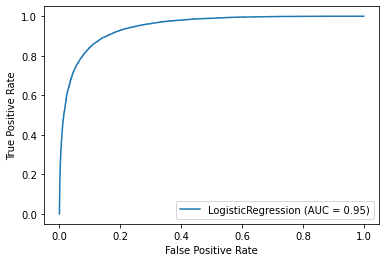

In [72]:
from sklearn.metrics import accuracy_score, f1_score, plot_roc_curve, roc_curve
log_reg_model = LogisticRegression(C=1, penalty='l1', solver='liblinear')
log_reg_model.fit(train_x_tfidf_1, train_y)
train_pred = log_reg_model.predict(train_x_tfidf_1)
test_pred = log_reg_model.predict(test_x_tfidf_1)

print("Training set performance")
print(f"Accuracy: {accuracy_score(train_y,train_pred)}")
print(f"F1 Score: {f1_score(train_y,train_pred)}")

print("-----------------")
print("Testing set performance")
print(f"Accuracy: {accuracy_score(test_y,test_pred)}")
print(f"F1 Score: {f1_score(test_y,test_pred)}")

test_pred_pos_prob = [lst[1] for lst in log_reg_model.predict_proba(test_x_tfidf_1)]
fpr, tpr, thresholds = roc_curve(y_score=test_pred_pos_prob,y_true=test_y, pos_label=1)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal TPR: {tpr[optimal_idx]}")
print(f"Optimal FPR: {fpr[optimal_idx]}")
plot_roc_curve(log_reg_model, test_x_tfidf_1, test_y)


## Identify Coefficients

Overall, the model makes sense. It associates positive sounding words with positive sentiment classifications, and negative sounding words for negative sentiment classifications.

The L1 regularizations conveniently eliminates a lot of words that have no directionality. 

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_corpus = train['preproc_text'].values
tfidf_1 = TfidfVectorizer(ngram_range=(1,1), min_df=2)
tfidf_1.fit(train_corpus)
log_reg_coefs = list(zip(tfidf_1.get_feature_names(), log_reg_model.coef_[0]))
log_reg_coefs_pd = pd.DataFrame({'var_name': [tup[0] for tup in log_reg_coefs], 'coef': [tup[1] for tup in log_reg_coefs]})
log_reg_coefs_pd

,var_name,coef
0,00s,0.0
1,10,0.0
2,1000,0.0
3,100min,0.0
4,100th,0.0
...,...,...
38247,zy,0.0
38248,zz,0.0
38249,élan,0.0
38250,émigré,0.0


In [102]:
#factors that predict a negative sentiment
log_reg_coefs_pd.sort_values('coef', ascending=True).head(20)

,var_name,coef
37745,worst,-20.824077
37010,waste,-16.947519
2296,awful,-15.187549
25821,poorly,-12.352630
9265,disappointment,-11.069421
10214,dull,-10.722295
3930,boring,-10.636810
11946,fails,-10.564024
9263,disappointing,-10.481223
25699,pointless,-10.011327


In [103]:
#factors that predict a positive sentiment
log_reg_coefs_pd.sort_values('coef', ascending=False).head(20)

,var_name,coef
11573,excellent,12.597217
25005,perfect,9.944312
37644,wonderfully,9.877279
14487,great,9.638790
27710,refreshing,9.186866
1090,amazing,8.960536
12175,favorite,8.694486
37642,wonderful,8.557940
15692,highly,8.543534
3186,best,8.008538


In [120]:
log_reg_results = train.copy()
OPTIMAL_CUTOFF_PROB = 0.49791
log_reg_results['pred_proba'] = [lst[1] for lst in log_reg_model.predict_proba(train_x_tfidf_1)]

log_reg_results['pred_label'] = (log_reg_results['pred_proba'] > OPTIMAL_CUTOFF_PROB).astype(int)
log_reg_results

,id,text,rating,label,preproc_text,pred_proba,pred_label
0,0,Bromwell High is a cartoon comedy. It ran at t...,9,pos,bromwell high cartoon comedy ran time program ...,0.573240,1
1,10000,Homelessness (or Houselessness as George Carli...,8,pos,homelessness houselessness george carlin state...,0.622133,1
2,10001,Brilliant over-acting by Lesley Ann Warren. Be...,10,pos,brilliant lesley ann warren best dramatic hobo...,0.977462,1
3,10002,This is easily the most underrated film inn th...,7,pos,easily underrated film inn brook cannon sure f...,0.749641,1
4,10003,This is not the typical Mel Brooks film. It wa...,8,pos,typical mel brook film much le slapstick movie...,0.908721,1
...,...,...,...,...,...,...,...
24995,9998,"Towards the end of the movie, I felt it was to...",4,neg,towards end movie felt technical felt like cla...,0.339544,0
24996,9999,This is the kind of movie that my enemies cont...,3,neg,kind movie enemy content watch time bloody tru...,0.075124,0
24997,999,I saw 'Descent' last night at the Stockholm Fi...,3,neg,saw last night stockholm film festival one hug...,0.005916,0
24998,99,Some films that you pick up for a pound turn o...,1,neg,film pick pound turn rather good 23rd century ...,0.011951,0


In [156]:
log_reg_results_sample = train_sample.copy()
log_reg_model_sample = LogisticRegression(C=1, penalty='l1', solver='liblinear')
log_reg_model_sample.fit(train_x_tfidf_1_sample, train_y_sample)
OPTIMAL_CUTOFF_PROB = 0.49791
log_reg_results_sample['pred_proba'] = [lst[1] for lst in log_reg_model_sample.predict_proba(train_x_tfidf_1_sample)]

log_reg_results_sample['pred_label'] = (log_reg_results_sample['pred_proba'] > OPTIMAL_CUTOFF_PROB).astype(int)
log_reg_results_sample

,id,text,rating,label,preproc_text,pred_proba,pred_label
0,9895,A bunch of popular high school students play a...,8,pos,bunch popular high school student play cruel j...,0.641911,1
1,1298,Sogo Ishii can be a skilled filmmaker under th...,3,neg,sogo ishii skilled filmmaker right condition g...,0.538692,1
2,942,Saw this late one night on cable. At the time ...,2,neg,saw late one night cable time know girl billed...,0.210082,0
3,9672,"While most of the movie is very amateurish, th...",3,neg,movie amateurish kosher slaughter scene played...,0.582733,1
4,11804,Rented the movie as a joke. My friends and I h...,10,pos,rented movie joke friend much fun laughing wen...,0.768801,1
...,...,...,...,...,...,...,...
2495,2209,"In my opinion, this is a pretty good celebrity...",8,pos,opinion pretty good celebrity skit show enjoye...,0.756161,1
2496,10784,It was disgusting and painful. What a waste of...,1,neg,disgusting painful waste cast swear audience f...,0.173736,0
2497,1526,"I may have seen worse films than this, but I i...",1,neg,may seen worse film remember possibly blocked ...,0.338006,0
2498,7283,Facts about National Lampoon Goes to the Movie...,1,neg,fact national lampoon go movie national lampoo...,0.085725,0


 # Business Context


One useful application area of our analysis is in the area of data driven movie direction. If movie producers can know beforehand, what factors lead to a positive sentiment among viewers (exemplified by high IMDB ratings), then they can better tailor their movie scripts to incorporate those themes. Let's explore this use case further below. 

To implement this use case, I do the following: 
- segement the predictions based on predicted sentiment (positive/negative) using the logistic regression model
- build a Latent Dirichlet Analysis (LDA) topic model on the positive predicted and negative predicted reviews separately 

## Segment the predictions by sentiment

In [167]:
pos_pred_reviews_sample = list(log_reg_results_sample[log_reg_results_sample['pred_label'] == 1]['preproc_text'].values)
neg_pred_reviews_sample = list(log_reg_results_sample[log_reg_results_sample['pred_label'] == 0]['preproc_text'].values)
pos_pred_reviews_sample = [review.split(" ") for review in pos_pred_reviews_sample]
neg_pred_reviews_sample = [review.split(" ") for review in neg_pred_reviews_sample]

## Build the LDA Topic Model

We build the model using the `gensim` library. 

In [197]:
#build dictionary (a mapping from a id to the actual word)
dictionary_pos = gensim.corpora.Dictionary(pos_pred_reviews_sample)
dictionary_neg = gensim.corpora.Dictionary(neg_pred_reviews_sample)
#filter out words that are too common (>10% of the corpus), and too rare (appear less than 5 times)
dictionary_pos.filter_extremes(no_below=5, no_above=0.1, keep_n=100000)
dictionary_neg.filter_extremes(no_below=5, no_above=0.1, keep_n=100000)
#convert each document in the corpus to a bag of words representation
bow_corpus_pos = [dictionary_pos.doc2bow(doc) for doc in pos_pred_reviews_sample]
bow_corpus_neg = [dictionary_neg.doc2bow(doc) for doc in neg_pred_reviews_sample]



Let's use a tfidf representation for each document, since the tfidf unigram feature set performs best with the logistic regression. 

In [198]:
#build the tfidf model
from gensim import corpora, models
tfidf_pos = models.TfidfModel(bow_corpus_pos)
tfidf_neg = models.TfidfModel(bow_corpus_neg)
corpus_tfidf_pos = tfidf_pos[bow_corpus_pos]
corpus_tfidf_neg = tfidf_neg[bow_corpus_neg]

After some experimental iterations, we note that the best num_topics to look for is around 5. 

In [199]:
#run the LDA model, and identify topics
lda_model_tfidf_pos = gensim.models.LdaMulticore(corpus_tfidf_pos, num_topics=5, id2word=dictionary_pos, 
                                                 passes=2, workers=4)
for idx, topic in lda_model_tfidf_pos.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.002*"fun" + 0.001*"horror" + 0.001*"american" + 0.001*"music" + 0.001*"kid" + 0.001*"wonderful" + 0.001*"anyone" + 0.001*"remember" + 0.001*"reason" + 0.001*"seeing"
Topic: 1 Word: 0.001*"war" + 0.001*"series" + 0.001*"funny" + 0.001*"sequence" + 0.001*"pretty" + 0.001*"tv" + 0.001*"che" + 0.001*"yet" + 0.001*"short" + 0.001*"worth"
Topic: 2 Word: 0.001*"music" + 0.001*"comedy" + 0.001*"true" + 0.001*"song" + 0.001*"episode" + 0.001*"actress" + 0.001*"loved" + 0.001*"audience" + 0.001*"fun" + 0.001*"need"
Topic: 3 Word: 0.002*"version" + 0.001*"funny" + 0.001*"favorite" + 0.001*"series" + 0.001*"book" + 0.001*"hard" + 0.001*"stanwyck" + 0.001*"paul" + 0.001*"house" + 0.001*"might"
Topic: 4 Word: 0.002*"episode" + 0.001*"watched" + 0.001*"job" + 0.001*"human" + 0.001*"funny" + 0.001*"probably" + 0.001*"tell" + 0.001*"french" + 0.001*"word" + 0.001*"child"


- Topic: 0 Word: 0.002*"fun" + 0.001*"horror" + 0.001*"american" + 0.001*"music" + 0.001*"kid" + 0.001*"wonderful" + 0.001*"anyone" + 0.001*"remember" + 0.001*"reason" + 0.001*"seeing"
- Topic: 1 Word: 0.001*"war" + 0.001*"series" + 0.001*"funny" + 0.001*"sequence" + 0.001*"pretty" + 0.001*"tv" + 0.001*"che" + 0.001*"yet" + 0.001*"short" + 0.001*"worth"
- Topic: 2 Word: 0.001*"music" + 0.001*"comedy" + 0.001*"true" + 0.001*"song" + 0.001*"episode" + 0.001*"actress" + 0.001*"loved" + 0.001*"audience" + 0.001*"fun" + 0.001*"need"
- Topic: 3 Word: 0.002*"version" + 0.001*"funny" + 0.001*"favorite" + 0.001*"series" + 0.001*"book" + 0.001*"hard" + 0.001*"stanwyck" + 0.001*"paul" + 0.001*"house" + 0.001*"might"
- Topic: 4 Word: 0.002*"episode" + 0.001*"watched" + 0.001*"job" + 0.001*"human" + 0.001*"funny" + 0.001*"probably" + 0.001*"tell" + 0.001*"french" + 0.001*"word" + 0.001*"child"


Topics present in the positive predicted reviews:
- Topic 0: American horror movies with kids, and music
- Topic 1: War series on TV that are short and have some humor 
- Topic 2: Musical comedies distributed as a series; where the actress feels loved and the audience has fun 
- Topic 3: Funny series that are based on a book with 
- Topic 4: Funny movies about jobs, children, and display a human, relatable element

In [200]:
#build the negative review LDA model
lda_model_tfidf_neg = gensim.models.LdaMulticore(corpus_tfidf_neg, num_topics=5, id2word=dictionary_neg, 
                                                 passes=2, workers=4)


for idx, topic in lda_model_tfidf_neg.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.002*"zombie" + 0.002*"may" + 0.002*"terrible" + 0.002*"ending" + 0.001*"music" + 0.001*"hour" + 0.001*"killer" + 0.001*"watched" + 0.001*"yet" + 0.001*"anyone"
Topic: 1 Word: 0.002*"book" + 0.002*"performance" + 0.002*"series" + 0.001*"need" + 0.001*"dialogue" + 0.001*"moment" + 0.001*"child" + 0.001*"terrible" + 0.001*"kid" + 0.001*"casting"
Topic: 2 Word: 0.002*"tv" + 0.001*"fan" + 0.001*"western" + 0.001*"wanted" + 0.001*"attempt" + 0.001*"money" + 0.001*"overall" + 0.001*"found" + 0.001*"move" + 0.001*"version"
Topic: 3 Word: 0.002*"book" + 0.001*"terrible" + 0.001*"special" + 0.001*"dvd" + 0.001*"anyone" + 0.001*"kid" + 0.001*"found" + 0.001*"poorly" + 0.001*"annoying" + 0.001*"boring"
Topic: 4 Word: 0.002*"boring" + 0.002*"comedy" + 0.002*"money" + 0.001*"friend" + 0.001*"hard" + 0.001*"laugh" + 0.001*"anyone" + 0.001*"rather" + 0.001*"moment" + 0.001*"ending"


- Topic: 0 Word: 0.002*"zombie" + 0.002*"may" + 0.002*"terrible" + 0.002*"ending" + 0.001*"music" + 0.001*"hour" + 0.001*"killer" + 0.001*"watched" + 0.001*"yet" + 0.001*"anyone"
- Topic: 1 Word: 0.002*"book" + 0.002*"performance" + 0.002*"series" + 0.001*"need" + 0.001*"dialogue" + 0.001*"moment" + 0.001*"child" + 0.001*"terrible" + 0.001*"kid" + 0.001*"casting"
- Topic: 2 Word: 0.002*"tv" + 0.001*"fan" + 0.001*"western" + 0.001*"wanted" + 0.001*"attempt" + 0.001*"money" + 0.001*"overall" + 0.001*"found" + 0.001*"move" + 0.001*"version"
- Topic: 3 Word: 0.002*"book" + 0.001*"terrible" + 0.001*"special" + 0.001*"dvd" + 0.001*"anyone" + 0.001*"kid" + 0.001*"found" + 0.001*"poorly" + 0.001*"annoying" + 0.001*"boring"
- Topic: 4 Word: 0.002*"boring" + 0.002*"comedy" + 0.002*"money" + 0.001*"friend" + 0.001*"hard" + 0.001*"laugh" + 0.001*"anyone" + 0.001*"rather" + 0.001*"moment" + 0.001*"ending"

Topics present in the negative predicted reviews:
- Topic 0: Zombie movies with terrible endings and killers in them 
- Topic 1: Movies with terrible casting for children with poor dialogue, based on books
- Topic 2: Western movies involving money distributed on TV
- Topic 3: Movies based on kids books distributed via DVD
- Topic 4: Comedies involving money, friends, and plain endings

**Please note that the above topic characterisations may changed with repeated reruns of the cell, since LDA results are sometimes variable.**

# Next Steps

If given more time, some next steps I would take are:
- Implement data augmentation techniques to make the classifier more robust to noise. One data augmentation technique I would consider is the Easy Data Augmentation technique for NLP. This is relevant because I sometimes sample the data to reduce running times, and might improve test performance for some of the models.
- Investigate the neural network based approaches (including perhaps attention mechanisms) since they are driving the state of the art in NLP.
- Investigate other topic models other than LDA. Perhaps, conduct a clustering analysis on the word vector representations? One drawback of LDa is that the topics extracted aren't stable; they tend to change from run to run. 